# フーリエ変換

FFTW.jlの`fft`関数と`fftfreq`関数の使い方についてまとめる。

## 問題設定

平均$\mu$、分散$\sigma$の正規化ガウス分布$f(x)$をフーリエ変換することを考える。

$$
\begin{aligned}
f(x) &= \frac{1}{\sqrt{\pi\sigma^2}} \exp{(-\frac{(x - \mu)^2}{\sigma^2})} \\
\mathcal{F}[f](k) &= \int_{-\infty}^{\infty} dx f(x) \exp{(-ikx)} \\
&= \int_{-\infty}^{\infty} dx \frac{1}{\sqrt{\pi\sigma^2}} \exp{(-\frac{(x - \mu)^2}{\sigma^2})} \exp{(-ikx)} \\
&= \exp{(-\frac{\sigma^2k^2}{4} - ik)} \\
&= \exp{(-\frac{(k - \frac{2}{i\sigma^2})}{4/\sigma^2})} \exp{(-\frac{1}{\sigma^2})}
\end{aligned}
$$

よって、ガウス分布のフーリエ変換もガウス分布になる。

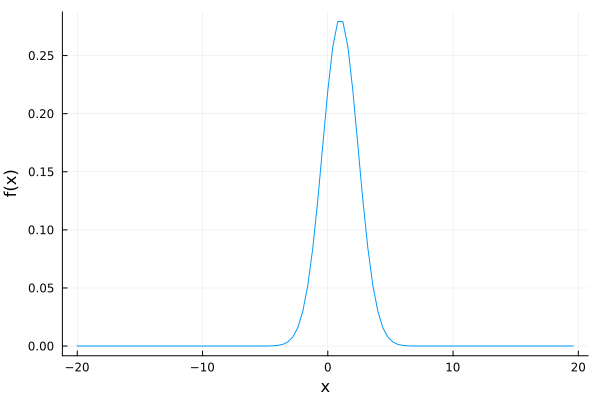

In [5]:
using FFTW
using Plots

# 関数の定義 ----------------------------------------------------
μ = 1.0
σ = 2.0
f(x) = exp(- (x - μ)^2 / σ^2) / (σ * sqrt(π))

# 実空間を離散化 -------------------------------------------------
L = 40      # 実空間のサイズ
N = 100     # 実空間の分割数
Δx = L / N  # 実空間の分割幅

# f(x)を計算 ----------------------------------------------------
x = range(-0.5L, length = N, step = Δx)
y = f.(x)
plot(x, y, label = nothing, xlabel = "x", ylabel = "f(x)")

## `fftfreq`

```doc
fftfreq(n, fs=1)

Return the discrete Fourier transform (DFT) sample frequencies for a DFT of length n. 
```


`fftfreq`関数は実空間$x$に対する波数空間$k$を返す。  
ただし、「角周波数」ではなく「周波数」を返すため、$2\pi$倍する必要があることに注意する。

k == k′ = true


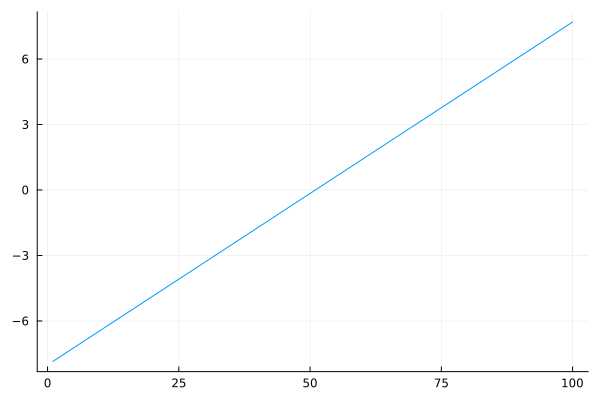

In [8]:
# 波数空間 ------------------------------------------------------
fs = 1 / Δx  # サンプリング周波数
k = 2π * fftfreq(N, fs) |> fftshift
# fftfreq(n, fs)
# 第一引数: 格子点の個数
# 第二引数: サンプリング周波数 = 分割幅の逆数


# シフトしたfftfreqは次と同等 ------------------------------------
Δk = 2π / (Δx * N)   # 波数空間の分割数
k′ = range(-π / Δx, length = N, step = Δk)
@show k == k′
plot(k, label = nothing)

また、$\Delta x \cdot \Delta k = \frac{2\pi}{N}$という関係にも注意する必要がある。  
すなわち、分割数$N$を固定したまま実空間の分割幅$\Delta x$と波数空間の分割幅$\Delta k$を同時に小さくすることはできない。

## `fft`

`fft`関数でフーリエ変換（厳密には離散フーリエ変換）を実行できる。  
離散フーリエ変換のため第$i$番目$(i = 1,2,...,N)$の値は$(-1)^{i-1}$倍されている。

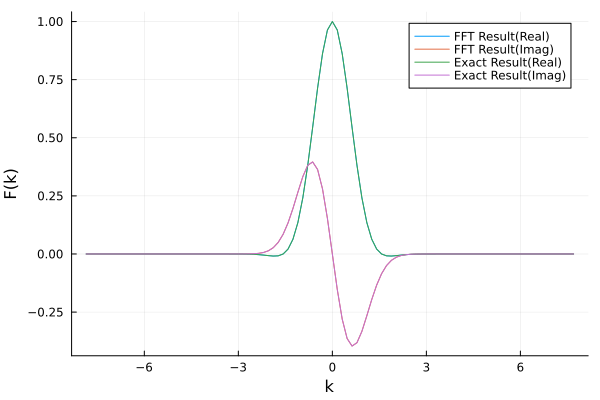

In [7]:
# 離散フーリエ変換を計算 ------------------------------------------
Y = fft(y) * Δx |>
    fftshift |>
    x -> -x .* (-1).^eachindex(x)  # 離散フーリエ変換のための補正

# フーリエ変換の厳密解を計算 --------------------------------------
F(k) = exp(-0.25 * σ^2 * k^2 - k * 1.0im)
Y_exact = F.(k)

# 計算結果を描画して比較 ------------------------------------------
plot(k, real(Y), label = "FFT Result(Real)", xlabel = "k", ylabel = "F(k)")
plot!(k, imag(Y), label = "FFT Result(Imag)")
plot!(k, real(Y_exact), label = "Exact Result(Real)")
plot!(k, imag(Y_exact), label = "Exact Result(Imag)")